<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания, предоставляющая услуги такси, собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. **Цель проекта** - построить модель для такого предсказания.

## Подготовка

In [1]:
pip install sweetviz

     |████████████████████████████████| 15.1 MB 2.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/datasets/taxi.csv')
display(df.head())
df.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Для более подробного анализа данных воспользуемся `sweetviz.analyze()`.

In [5]:
report = sv.analyze(df)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Выявлено, что дубликатов и пропущенных значений нет. Также нет выпадающих значений и аномалий - количество такси, которые могут быть вызваны в течение 10 минут вполне реальное. Но для дальнейшей работы с данными необходимо перевести дату из *object* в формат *datetime64*, сделать её индексом, отсортировать и проверить, действительно ли данные расположены в хронологическом порядке.

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('datetime')
df = df.sort_index()
print(df.index.is_monotonic)

True


Данные расположены хронологически. Теперь выполним ресемплирование по одному часу. Для наглядности построим график.

<AxesSubplot:xlabel='datetime'>

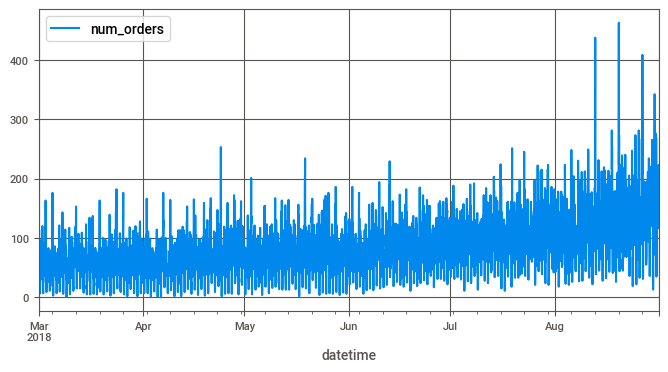

In [7]:
df_new = df.resample('1H').sum().astype('int')
df_new.plot(figsize=(8,4), grid=True)

###  Вывод

При поготовке данных:
- не выявлено дубликатов, пропущенных значений и аномалий;
- дата переведена в формат *datetime64*, отсортирована в хронологическом порядке и сделана индексом;
- проведено ресемплирование по одному часу.

## Анализ

В данном разделе проанализируем временной ряд на тренд и сезонность. Также необходимо подготовить данные для обучения моделей: создать признаки, выделить обучающую и тестовую выборки, разбить выборки на целевой признак и фичи.

In [8]:
decomposed = seasonal_decompose(df_new)

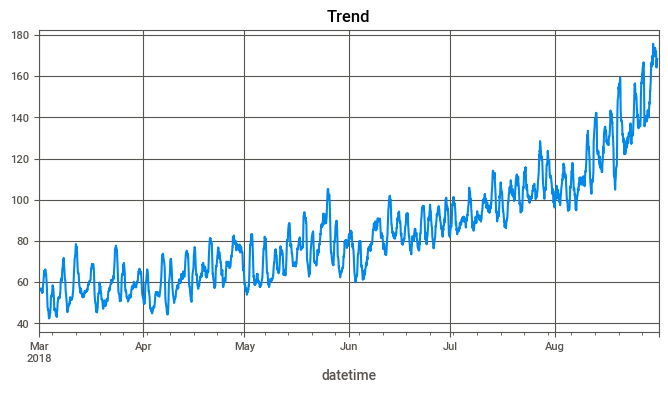

In [9]:
decomposed.trend.plot(figsize=(8,4), grid=True)
plt.title('Trend')
plt.show()

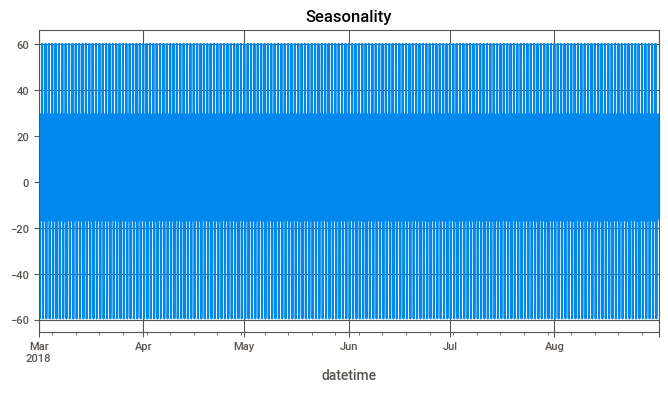

In [10]:
decomposed.seasonal.plot(figsize=(8,4), grid=True)
plt.title('Seasonality')
plt.show()

- На графике тренда можно увидеть увеличение числа заказанных такси с наступлением лета. В июне, июле и августе больше людей прилетают в город в отпуск, и количество заказов резко возрастает.
- Сезонность явно связана с периодом меньше месяца, исследуем её дальше и возьмём период в одну неделю.

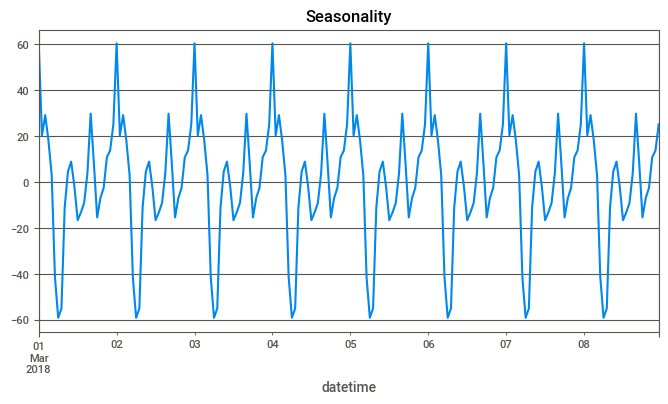

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(figsize=(8,4), grid=True)
plt.title('Seasonality')
plt.show()

Меньше всего заказов приходится на утренние часы, далее в течении дня количество заказов растёт. Самый пик заказов приходится ближе к 10-11 вечера.

Теперь напишем функцию для создания признаков - календарных, отстающих значений и скользящих средних. Пропущенные значения пока не будем убирать, сделаем это позже. Функция должна возвращать новый датафрейм с исходными данными и полученными признаками.

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    df = pd.DataFrame(index=data.index)
    df = df.join(data)
    df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

df_final = make_features(df_new, 24, 120)
df_final.tail()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,158.533333
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,158.616667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,158.883333
2018-08-31 22:00:00,223,2018,8,31,4,159.0,154.0,136.0,207.0,217.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,159.316667
2018-08-31 23:00:00,205,2018,8,31,4,223.0,159.0,154.0,136.0,207.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,159.966667


Теперь разделим данные на тестовую и обучающую выборки и проверим, что тестовая выборки идёт в хронологическом порядке после обучающей. Так как в обучающей выборке остались строки с пропущенными значениями, их необходимо убрать.

In [13]:
train, test = train_test_split(df_final, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-06 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Всё в порядке, теперь осталось выделить в выборках целевой признак и фичи.

In [14]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

###  Вывод

При анализе данных:
- выявили, что тренд связан с увеличением числа заказов в летний сезон;
- выявлили, что сезонность связана с временем суток - в утренние часы количество заказов меньше всего, а в 10-11 вечера - больше;
- разделили данные на тестовую и обучающую выборки в соотношение 1:9;
- выделили в выборках целевой признак и фичи.

## Обучение

Для обучения моделей воспользуемся `GridSearchCV()`. Обучим несколько моделей: Градиентный бустинг (CatBoost, LightGBM), Дерево решений, Случайный лес. Для Линейной регрессии используем кросс-валидацию.

### CatBoost

In [15]:
parameters_cbr = {'learning_rate' : [0.03, 0.04, 0.05],
                 'depth' : range (5, 10)
                }

In [16]:
%%time

CBR = GridSearchCV(CatBoostRegressor(iterations=500), parameters_cbr, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit())
CBR.fit(features_train, target_train)
rmse = CBR.best_score_
best_model_cbr = CBR.best_estimator_
print(CBR.best_params_)
print('RMSE модели:', abs(rmse.round(2))) # берём оценку по модулю, так как 'neg_root_mean_squared_error' возвращает отрицательные значения

0:	learn: 28.9206178	total: 49.3ms	remaining: 24.6s
1:	learn: 28.5731396	total: 51.6ms	remaining: 12.9s
2:	learn: 28.2368622	total: 54.9ms	remaining: 9.09s
3:	learn: 27.8867471	total: 57.9ms	remaining: 7.18s
4:	learn: 27.5509987	total: 61.7ms	remaining: 6.1s
5:	learn: 27.2232045	total: 64.4ms	remaining: 5.3s
6:	learn: 26.8786069	total: 66.6ms	remaining: 4.69s
7:	learn: 26.5549448	total: 68.9ms	remaining: 4.24s
8:	learn: 26.2687370	total: 70.9ms	remaining: 3.87s
9:	learn: 26.0019287	total: 72.9ms	remaining: 3.57s
10:	learn: 25.7260293	total: 75ms	remaining: 3.33s
11:	learn: 25.4578406	total: 77.2ms	remaining: 3.14s
12:	learn: 25.2111517	total: 79.3ms	remaining: 2.97s
13:	learn: 24.9865149	total: 81.6ms	remaining: 2.83s
14:	learn: 24.7336984	total: 83.7ms	remaining: 2.71s
15:	learn: 24.5122981	total: 85.8ms	remaining: 2.6s
16:	learn: 24.2944528	total: 87.9ms	remaining: 2.5s
17:	learn: 24.1161522	total: 90ms	remaining: 2.41s
18:	learn: 23.8920421	total: 92.5ms	remaining: 2.34s
19:	learn: 

### LightGBM

In [17]:
parameters_lgbm = {'learning_rate' : [0.03, 0.04, 0.05],
                   'max_depth' : range (5, 10)
                  }

In [18]:
%%time

LGBMR = GridSearchCV(LGBMRegressor(), parameters_lgbm, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit())
LGBMR.fit(features_train, target_train)
best_model_lgbmr = LGBMR.best_estimator_
rmse = LGBMR.best_score_
print(LGBMR.best_params_)
print('Значение RMSE:', abs(rmse.round(2)))

{'learning_rate': 0.04, 'max_depth': 9}
Значение RMSE: 25.55
CPU times: user 53min 57s, sys: 20.2 s, total: 54min 17s
Wall time: 54min 45s


### Дерево решений

In [19]:
state = np.random.RandomState(12345)

In [20]:
parameters_dtr = {'max_depth': range (1,10),
                 'min_samples_leaf': range (1,10),
                 'min_samples_split': range(2,10)
                }

In [21]:
%%time

DTR = GridSearchCV(DecisionTreeRegressor(random_state=state), parameters_dtr, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit())
DTR.fit(features_train, target_train)
best_model_dtr = DTR.best_estimator_
rmse = DTR.best_score_
print(DTR.best_params_)
print('Значение RMSE:', abs(rmse.round(2)))

{'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
Значение RMSE: 29.73
CPU times: user 1min 5s, sys: 77.1 ms, total: 1min 5s
Wall time: 1min 5s


###  Случайный лес

In [22]:
parameters_rfr = {'max_depth': range (1, 10),
                 'n_estimators': range (60, 200, 10)
                }

In [23]:
%%time
RFR = GridSearchCV(RandomForestRegressor(random_state=state), parameters_rfr, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit())
RFR.fit(features_train, target_train)
best_model_rfr = RFR.best_estimator_
rmse = RFR.best_score_
print(RFR.best_params_)
print('Значение RMSE:', abs(rmse.round(2)))

{'max_depth': 9, 'n_estimators': 100}
Значение RMSE: 25.93
CPU times: user 13min 48s, sys: 2.09 s, total: 13min 50s
Wall time: 13min 51s


### Линейная регрессия

In [24]:
%%time

LR = LinearRegression()
scores_LR = cross_val_score(LR, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit())
rmse = abs(scores_LR).mean()
print('Значение RMSE:', rmse.round(2))

Значение RMSE: 27.41
CPU times: user 312 ms, sys: 806 ms, total: 1.12 s
Wall time: 1.07 s


### Вывод

- По значению RMSE модели Дерево решений(RMSE=29.73), Случайный лес(RMSE=25.93) и Линейная регрессия(RMSE=27.41) получились наименее качественными, поэтому их не рекомендуется брать.
- Модели Градиентного бустинга CatBoost(RMSE=24.8) и LightGBM(RMSE=25.55) получились достаточно качественными, но модель LightGBM занимает слишком много времени, поэтому учитывая качество и время работы выбираем модель CatBoost.

## Тестирование

Протестируем модель на тестовой выборке и проверим её на адекватность.

In [28]:
%%time
best_model_cbr.fit(features_train, target_train)
rmse = mean_squared_error(target_test, best_model_cbr.predict(features_test), squared=False).round(2)
print('Значение RMSE:', rmse)

0:	learn: 37.9473084	total: 10.3ms	remaining: 5.13s
1:	learn: 37.2635495	total: 20.5ms	remaining: 5.11s
2:	learn: 36.6932718	total: 30.7ms	remaining: 5.08s
3:	learn: 36.1297592	total: 40.6ms	remaining: 5.03s
4:	learn: 35.5303823	total: 51.2ms	remaining: 5.07s
5:	learn: 34.9617603	total: 61.6ms	remaining: 5.08s
6:	learn: 34.4131043	total: 75ms	remaining: 5.28s
7:	learn: 33.8838216	total: 86.9ms	remaining: 5.35s
8:	learn: 33.4124179	total: 97.8ms	remaining: 5.33s
9:	learn: 32.9281826	total: 108ms	remaining: 5.29s
10:	learn: 32.4742933	total: 118ms	remaining: 5.26s
11:	learn: 32.0362902	total: 129ms	remaining: 5.24s
12:	learn: 31.6323153	total: 139ms	remaining: 5.2s
13:	learn: 31.2325469	total: 150ms	remaining: 5.2s
14:	learn: 30.8744480	total: 161ms	remaining: 5.2s
15:	learn: 30.5359865	total: 176ms	remaining: 5.33s
16:	learn: 30.2164858	total: 187ms	remaining: 5.31s
17:	learn: 29.9069493	total: 197ms	remaining: 5.28s
18:	learn: 29.6207791	total: 208ms	remaining: 5.26s
19:	learn: 29.3315

Значение RMSE на тестовой выборке 41.92, что соответствует условию поставленной задачи.

Проверку на адекватность будем осуществлять при помощи медианного значением.

In [26]:
pred_median = np.ones(target_test.shape) * target_test.median()
print("RMSE:", mean_squared_error(target_test, pred_median, squared=False).round(2))

RMSE: 58.73


Значение RMSE больше, чем у выбранной модели. Проверка на адекватность пройдена.

Для наглядности построим графики реальных данных и значений, предсказанных выбранной моделью.

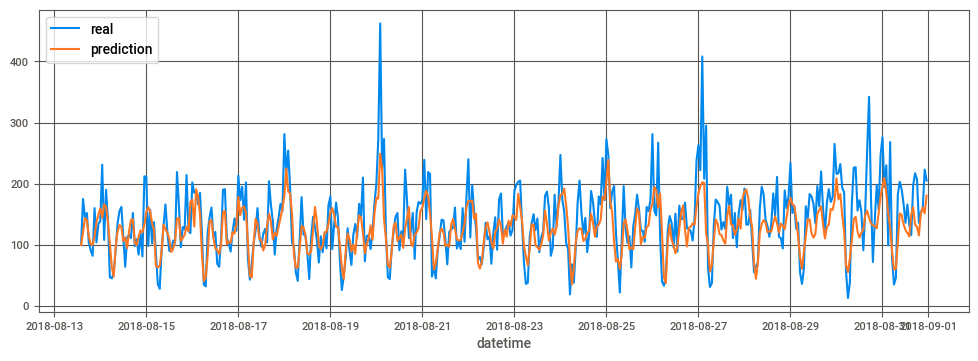

In [29]:
prediction = pd.DataFrame(data=best_model_cbr.predict(features_test), index=target_test.index)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(target_test, label='real')
ax.plot(prediction, label='prediction')
ax.legend(loc='upper left')
ax.set_xlabel('datetime')
ax.grid(True)
plt.show()

## Вывод

Для прогнозирования количества заказов такси на следующий час рекомендуется использовать модель Градиентного бустинга CatBoost, так как значение RMSE на обучающей выборке у неё самое меньшее и времени на обучение и предсказание уходит сравнительно немного. 

На тестовой выборке значение RMSE у модели CatBoost получилось 41.92, что соответствует условию поставленной задачи.